In [1]:
import os
import sys
# import torch.multiprocessing as mp
# from functools import partial

import pytorch_lightning as pl
import torch
import torch.nn.functional as F
import torch.utils.data as data
import torchvision.models as models
from PIL import Image
from compressai.models import ScaleHyperprior
from compressai.zoo import bmshj2018_hyperprior
from torch import optim, nn, utils
from torchvision import transforms
from torchmetrics import Accuracy

import wandb
from pytorch_lightning.loggers import WandbLogger
import pickle

# mp.set_start_method('spawn', force=True)
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [2]:
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3,
                     stride=stride, padding=1, bias=False)


# 1x1 convolution
def conv1x1(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=1,
                     stride=stride, bias=False)


# Residual block
class ResidualBlock(nn.Module):

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv1x1(in_channels, in_channels, stride)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv2 = conv3x3(in_channels, in_channels)
        self.bn2 = nn.BatchNorm2d(in_channels)
        self.conv3 = conv1x1(in_channels, out_channels, stride)
        self.bn3 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out


class cResnet39(pl.LightningModule):
    def __init__(self):
        super().__init__()

        # init a pretrained resnet
        backbone = models.resnet50(weights="DEFAULT")
        layers = nn.ModuleList(list(backbone.children())[5:-1])

        self.in_channels = 192
        self.layer1_y_hat = self.make_layer(ResidualBlock, 128, 1)

        self.in_channels = 192
        self.layer1_scales_hat = self.make_layer(ResidualBlock, 128, 1)

        self.feature_extractor = nn.Sequential(*layers)

        num_target_classes = 23
        # self.classifier = nn.Linear(128*2048, 23)
        self.classifier = nn.Linear(2048, 23)
        
        
        
        self.training_targets = []
        self.validation_targets = []
        
        self.training_predictions = []
        self.validation_predictions = []
        
        self.training_step_losses = []
        self.validation_step_losses = []
        
        self.top1_accuracy = Accuracy(task="multiclass", num_classes=num_target_classes)
        self.top5_accuracy = Accuracy(task="multiclass", num_classes=num_target_classes, top_k=5)
        
        # save hyper-parameters to self.hparamsm auto-logged by wandb
        self.save_hyperparameters()
        

    def make_layer(self, block, out_channels, blocks, stride=1):

        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv1x1(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = nn.ModuleList()
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))

        # print(*layers)
        return nn.Sequential(*layers)

    def forward(self, y_hat, scales_hat):
        y_hat = self.layer1_y_hat(y_hat.T)
        scales_hat = self.layer1_scales_hat(scales_hat.T)

        x = torch.concat((y_hat, scales_hat), 1)
        
        # self.feature_extractor.eval()
        # with torch.no_grad():
        representations = self.feature_extractor(x)

        representations = representations.view(representations.size(0), -1)
        
        output = self.classifier(representations)
        return output

    def training_step(self, batch, batch_idx):
        x, y_hat, scales_hat, target = batch
        target = target.to(device)

        y_hat, scales_hat = y_hat.to(device), scales_hat.to(device)
      
        predict = self.forward(y_hat.T, scales_hat.T)
        batch_loss = F.cross_entropy(predict, target)
        
        self.training_step_losses.append(batch_loss)

        self.training_targets.append(target)
        self.training_predictions.append(predict)
        
        return batch_loss
    
    def validation_step(self, batch, batch_idx):
        x, y_hat, scales_hat, target = batch
        
        target = target.to(device)

        y_hat, scales_hat = y_hat.to(device), scales_hat.to(device)
      
        with torch.no_grad():
            predict = self.forward(y_hat.T, scales_hat.T)
            batch_loss = F.cross_entropy(predict, target)
            
        self.validation_step_losses.append(batch_loss)

            
        self.validation_targets.append(target)
        self.validation_predictions.append(predict)
        
        return batch_loss
    
    def on_train_epoch_end(self):
        # print(torch.cat(self.training_targets).shape)
        # print(torch.cat(self.training_predictions).shape)
        
        loss = F.cross_entropy(torch.cat(self.training_predictions), torch.cat(self.training_targets))
        # loss1 = sum(self.training_step_losses) / len(self.training_step_losses)
        top1_accuracy = self.top1_accuracy(torch.cat(self.training_predictions), torch.cat(self.training_targets)) 
        top5_accuracy = self.top5_accuracy(torch.cat(self.training_predictions), torch.cat(self.training_targets)) 
        print("\nTrain loss:", loss)
        print("Train top-1 acc:", top1_accuracy)
        print("Train top-5 acc:", top5_accuracy)
        self.log("train loss", loss)
        self.log("train top-1 acc", top1_accuracy)
        self.log("train top-5 acc", top5_accuracy)
        self.training_targets.clear()
        self.training_predictions.clear()
        self.training_step_losses.clear()
        
    def on_validation_epoch_end(self):
        print(torch.cat(self.validation_targets).shape)
        print(torch.cat(self.validation_predictions).shape)
        
        loss = F.cross_entropy(torch.cat(self.validation_predictions), torch.cat(self.validation_targets))
        top1_accuracy = self.top1_accuracy(torch.cat(self.validation_predictions), torch.cat(self.validation_targets)) 
        top5_accuracy = self.top5_accuracy(torch.cat(self.validation_predictions), torch.cat(self.validation_targets)) 
        # loss = sum(self.validation_step_losses) / len(self.validation_step_losses)
        
        print("\nVal loss:", loss)
        print("Val top-1 acc:", top1_accuracy)
        print("Val top-5 acc:", top5_accuracy)
        self.log("val loss", loss)
        self.log("val top-1 acc", top1_accuracy)
        self.log("val top-5 acc", top5_accuracy)
        self.validation_targets.clear()
        self.validation_predictions.clear()
        self.validation_step_losses.clear()
    

    def configure_optimizers(self):
        optimizer = optim.SGD(self.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
        return [optimizer], [{"scheduler": scheduler, "interval": "epoch"}]
        
        # return optimizer

In [3]:
def find_classes(dir):
    classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx

def make_dataset(filename, datadir, class_to_idx, transform=None):
    images = []
    labels = []
    i = 0
    with open(os.path.join(filename), "r") as lines:
        for line in lines:
            _image = os.path.join(datadir, line.rstrip('\n'))
            _dirname = os.path.split(os.path.dirname(_image))[1]
            assert os.path.isfile(_image)
            label = class_to_idx[_dirname]
            images.append(_image)
            labels.append(label)
            i += 1
            if i % 1000 == 0: sys.stdout.write('\r'+str(i)+' items loaded')
            
    sys.stdout.write('\r'+str(i)+' items loaded')
                           
              
    return images, labels

def preprocess_dataset(root=os.path.expanduser('./')):
    
    root = os.path.join(root, 'minc-mini')
    print(root)

    classes, class_to_idx = find_classes(root + '/images')
    
    for filename in [os.path.join(root, 'labels/train1.txt'), os.path.join(root, 'labels/validate1.txt'), os.path.join(root, 'labels/test1.txt')]:
        print("File: ", filename)

        for quality in [1]:
            print("Quality:", quality)
            compression_model = bmshj2018_hyperprior(quality=quality, pretrained=True).eval().to(device)

            i = 0
            with open(os.path.join(filename), "r") as lines:
                for line in lines:
                    _image = os.path.join(root, line.rstrip('\n'))
                    _dirname = os.path.split(os.path.dirname(_image))[1]
                    _file_name = os.path.join(root, 'compressed_rep', f'bpp{quality}', _dirname, os.path.splitext(os.path.split(_image)[1])[0])
                    assert os.path.isfile(_image)
                    # print(_image, _file_name, _dirname)

                    _img = Image.open(_image).convert('RGB')

                    _img = transforms.ToTensor()(_img)
                    _img = transforms.Resize(384)(_img)

                    _img = _img.unsqueeze(0).to(device)

                    with torch.no_grad():
                        compressed_rep = compression_model.compress(_img)

                    # print(compressed_rep)

                    with open(_file_name, 'wb') as handle:
                        pickle.dump(compressed_rep, handle, protocol=pickle.HIGHEST_PROTOCOL)

                    i += 1
                    if i % 1000 == 0: sys.stdout.write('\r'+str(i)+' items loaded')

        sys.stdout.write('\r'+str(i)+' items loaded')

        

preprocess_dataset()

./minc-mini
File:  ./minc-mini/labels/train1.txt
Quality: 1


/home/kgupta_umass_edu/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


25 items loadedFile:  ./minc-mini/labels/validate1.txt
Quality: 1
0 items loadedFile:  ./minc-mini/labels/test1.txt
Quality: 1
0 items loaded

In [10]:
# We use the train-validation-test split
# 1 provided in the dataset, with 2125 training images, 125
# validation images and 250 testing images for each class.

class MINCDataset(data.Dataset):
    NUM_CLASS = 23

    def __init__(self, root=os.path.expanduser('./'),
                 split = 'train', quality=1):
        
        root = os.path.join(root, 'minc-mini')
        print(root)
        
        self.classes, self.class_to_idx = find_classes(root + '/images')
        if split == 'train':
            filename = os.path.join(root, 'labels/train1.txt') # 2125
        else:
            filename = os.path.join(root, 'labels/validate1.txt') # 125

        self.images, self.crs, self.labels = make_dataset(filename, root, self.class_to_idx, quality)
        
        self.compression_model = bmshj2018_hyperprior(quality=quality, pretrained=True).eval().to(device)

        assert (len(self.images) == len(self.labels))

    def __getitem__(self, index):
        _image = self.images[index]
        _img = Image.open(_image).convert('RGB')
        _label = self.labels[index]
        
        _img = transforms.ToTensor()(_img)
        _img = transforms.Resize(384)(_img)
    
        _img = _img.unsqueeze(0).to(device)
        
        _compressed_rep = self.crs[index]

        with open(_compressed_rep, 'rb') as handle:
            compressed_rep = pickle.load(handle)
        
        
        with torch.no_grad():
            _z_hat = self.compression_model.entropy_bottleneck.decompress(compressed_rep['strings'][1], compressed_rep['shape'])
            _scales_hat = self.compression_model.h_s(_z_hat)
            _indexes = self.compression_model.gaussian_conditional.build_indexes(_scales_hat)
            _y_hat = self.compression_model.gaussian_conditional.decompress(compressed_rep['strings'][0], _indexes, _z_hat.dtype)
        
        _y_hat, _scales_hat = torch.squeeze(_y_hat, 0).to(device), torch.squeeze(_scales_hat, 0).to(device)
        _y_hat = transforms.Resize(32)(_y_hat)
        _scales_hat = transforms.Resize(32)(_scales_hat)
        _y_hat = transforms.RandomCrop(28)(_y_hat)
        _scales_hat = transforms.RandomCrop(28)(_scales_hat)
        
        p = float(torch.randint(0, 2, (1, )).item())
        _y_hat = transforms.RandomHorizontalFlip(p=p)(_y_hat)
        _scales_hat = transforms.RandomHorizontalFlip(p=p)(_scales_hat)

        return _image, _y_hat, _scales_hat, _label

    def __len__(self):
        return len(self.images)


def find_classes(dir):
    classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx


def make_dataset(filename, datadir, class_to_idx, quality):
    images = []
    labels = []
    crs = []
    
    i = 0
    with open(os.path.join(filename), "r") as lines:
        for line in lines:
            _image = os.path.join(datadir, line.rstrip('\n'))
            _dirname = os.path.split(os.path.dirname(_image))[1]
            _compressed_rep = os.path.join(datadir, 'compressed_rep', f'bpp{quality}', _dirname, os.path.splitext(os.path.split(_image)[1])[0])
            assert os.path.isfile(_image)
            assert os.path.isfile(_compressed_rep)
            label = class_to_idx[_dirname]
            images.append(_image)
            crs.append(_compressed_rep)
            labels.append(label)
            
            i += 1
            if i % 1000 == 0: sys.stdout.write('\r'+str(i)+' items loaded')
            
    sys.stdout.write('\r'+str(i)+' items loaded')
                           
              
    return images, crs, labels

In [11]:
train_minc = MINCDataset(split='train')
train_loader = utils.data.DataLoader(train_minc, batch_size=4)

./minc-mini
25 items loaded

In [12]:
checkpoint_reference = "umass-iesl-is/696ds-learning-based-image-compression/model-sh08q7s9:v0"

# download checkpoint locally (if not already cached)
run = wandb.init(project='696ds-learning-based-image-compression')
artifact = run.use_artifact(checkpoint_reference, type="model")
artifact_dir = artifact.download()

# load checkpoint
downstream_model = cResnet39.load_from_checkpoint(os.path.join(artifact_dir,"model.ckpt"))

wandb: Downloading large artifact model-sh08q7s9:v0, 184.73MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.4


In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

/home/kgupta_umass_edu/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


top 1: 0.75
top 5: 1.0
loss : 1.219136118888855
Label 0
Label 0
Label 0
Label 1


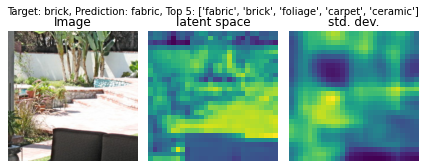

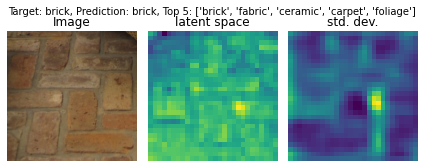

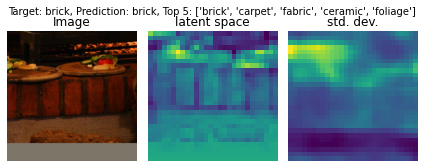

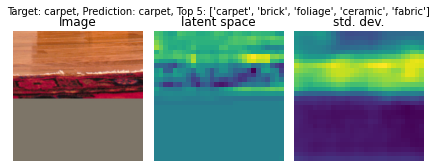

In [14]:
downstream_model.to(device).eval()

with torch.no_grad():
    for batch_idx, batch in enumerate(train_loader):
        x, y_hat, scales_hat, target = batch
        target = target.to(device)

        y_hat, scales_hat = y_hat.to(device), scales_hat.to(device)

        predict = downstream_model(y_hat.T, scales_hat.T)
        loss = F.cross_entropy(predict, target)
        print("top 1:", Accuracy(task="multiclass", num_classes=23).to(device)(predict, target).item())
        print("top 5:", Accuracy(task="multiclass", num_classes=23, top_k=5).to(device)(predict, target).item())
        print("loss :", loss.item())
        
        for idx, img in enumerate(x):
            print("Label", target[idx].item())
            
            img = Image.open(img).convert('RGB')
            
            f, axarr = plt.subplots(1,3)
            axarr[0].axis('off')
            axarr[1].axis('off')
            axarr[2].axis('off')
            
            axarr[0].imshow(img)
            axarr[0].title.set_text('Image')
            
            axarr[1].imshow(y_hat[idx].sum(axis=0).cpu())
            axarr[1].title.set_text('latent space')
            
            axarr[2].imshow(scales_hat[idx].sum(axis=0).cpu())
            axarr[2].title.set_text('std. dev.')
            
            f.suptitle(f'Target: {train_minc.classes[target[idx].item()]}, Prediction: {train_minc.classes[torch.argmax(predict[idx])]}, Top 5: {[train_minc.classes[p] for p in torch.topk(predict[idx], 5).indices.tolist()]}', fontsize=10)
            f.tight_layout()
            f.subplots_adjust(top=1.3)
        
        break
            
            
wandb.finish()

In [15]:
wandb.finish() 